# Taxi Trip Geospatial Cleaning 

In this notebook we look to clean a dataset containing information around individual taxi trips in and around New York City. In particular we are focusing on the pickup and drop off locations of the trips. 

## Whats wrong with the data
Below we can see that pickup and dropoff have very large ranges between their maximum and minimum coordinates. A quick google puts NYC between -73.7 and -74.26 longitude, and between  40.92 and 40.497 latitude which was much smaller than the ranges within the data.

## How do we solve this?
There is no one method to solving a problem like this, in this notebook we will be attempting to filter out bad points spatially. As in drawing a polygon around NYC where points outside the polygon should be removed from the sample. This polygon requiers a certain assumption as to where data is considered valid or not. In a business case this is a decision typically made by a SME (subject matter expert) or a PO (product owner).

Our first step is to get rid of the obviously wrong data. Drawing a box or circle around the city with a certain size and then eliminating any points that reside outside of the polygon. This is crude but efficient, it will prove very effective when coupled with a mroe accurate second method.

An assumption made for this notebook is that a taxi in NYC is far more likely to conduct its pickups within NYC than outisde. Thus a way to accurately identify bad data is to focus on the pickup-locations. We can restrict pickup locations to within ciity limits and restrict dropoff locations to the arbitrary bounding box.

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import pyreadr
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin

#### Using python with .rds (R data file) requires some conversion. In python the object we use is called a dataframe and it comes with the Pandas package.

In [2]:
# Read RDS file into pandas dataframe
data = pyreadr.read_r('nyc_taxi_data_clean_medium.rds')
df = data[None]

#### Below we see the evidence of the distorted data. Range between min and max is far too big

In [3]:
df['pickup_longitude'].describe() # Get basic data spread

count    1.482876e+07
mean    -7.397209e+01
std      5.687341e-01
min     -1.578177e+02
25%     -7.399230e+01
50%     -7.398200e+01
75%     -7.396786e+01
max      1.009878e+02
Name: pickup_longitude, dtype: float64

In [4]:
df['pickup_latitude'].describe()

count    1.482876e+07
mean     4.074886e+01
std      4.866608e-01
min     -7.401636e+01
25%      4.073654e+01
50%      4.075343e+01
75%      4.076788e+01
max      7.401463e+01
Name: pickup_latitude, dtype: float64

In [5]:
df['dropoff_longitude'].describe()

count    1.482876e+07
mean    -7.397145e+01
std      5.783764e-01
min     -1.578177e+02
25%     -7.399161e+01
50%     -7.398048e+01
75%     -7.396500e+01
max      1.009878e+02
Name: dropoff_longitude, dtype: float64

In [6]:
df['dropoff_latitude'].describe()

count    1.482876e+07
mean     4.074936e+01
std      4.896054e-01
min     -7.406991e+01
25%      4.073556e+01
50%      4.075394e+01
75%      4.076857e+01
max      7.403593e+01
Name: dropoff_latitude, dtype: float64

#### We should also confirm what data we have to work with other than the coordinates. Two in particular are useful. 

#### The first is bad_data_flag. This is what we will be updating to identify when a data point is suspected to be invalid. It also allows us to input some reasoning as to why the data is invalid.

#### The second is randID. This can be used to select a subset of this data to operate on, especially useful if the machine you are operating on has low memory capacity.

In [7]:
 df = df[df['randID'] == 15].copy() # Sample the data ~1%

In [8]:
# See what columns we have to work with and how much memory we are using. Without sampling it would be 5.4gb in ram!
df.info(memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150493 entries, 129 to 14828754
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   medallion             150493 non-null  object  
 1   hack_license          150493 non-null  object  
 2   vendor_id             150493 non-null  category
 3   rate_code             150493 non-null  category
 4   store_and_fwd_flag    150493 non-null  category
 5   pickup_datetime       150493 non-null  float64 
 6   dropoff_datetime      150493 non-null  float64 
 7   passenger_count       150493 non-null  int32   
 8   trip_time_in_secs     150493 non-null  int32   
 9   trip_distance         150493 non-null  float64 
 10  pickup_longitude      150493 non-null  float64 
 11  pickup_latitude       150493 non-null  float64 
 12  dropoff_longitude     150493 non-null  float64 
 13  dropoff_latitude      150493 non-null  float64 
 14  payment_type          150493 non

#### The structure of the data doesn't change from R to a pyhton dataframe. We can explore through the data as such. 

In [9]:
print(df.shape)
print(df.columns)

(150493, 25)
Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge',
       'mta_tax', 'tips', 'tolls', 'total_amount', 'randID',
       'dropoff_minus_pickup', 'bad_data_flag', 'tips_percent'],
      dtype='object')


In [10]:
df.head(1000)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,fare_amount,surcharge,mta_tax,tips,tolls,total_amount,randID,dropoff_minus_pickup,bad_data_flag,tips_percent
129,F0F0CFE0F353AAB5F87B98BC37C5540D,037BB8A7D2501F9CDCCC70F271A356D6,CMT,1,N,15800.216574,15800.223252,1,577,3.40,...,12.5,0.5,0.5,2.00,0.00,15.50,15,0.006678,,16.000000
167,5C96FE79A28D617F9933C387A65A3061,BDDFA029563EC82E16C335A5B3B1C57F,VTS,1,,15807.981944,15807.989583,1,660,1.83,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.007639,,21.052632
377,85720A3C71973D86C8CA39B0B79B6968,DEF7DC1592397F0C2564B0ABFA2A7CF4,VTS,1,,15807.835417,15807.845139,1,840,5.02,...,16.5,0.5,0.5,4.25,0.00,21.75,15,0.009722,,25.757576
416,62099C3783738399C97EE0D4E35A3F0A,D2923683CFECDB4AECB0D995716F35FF,VTS,1,,15807.878472,15807.888889,1,900,2.84,...,12.5,0.5,0.5,0.00,0.00,13.50,15,0.010417,,0.000000
481,CAC816D410FB0B7B8F3B4B1F39680F97,A9F126F43FAFF4097D227EA49EBCAEEF,VTS,1,,15807.923611,15807.930556,6,600,2.26,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.006944,,21.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100112,58A9ED83D9C9C7481B87ED554AEC24C4,084BEA6D22BB8589234B589E01D00BF1,VTS,1,,15808.347917,15808.349306,1,120,0.23,...,3.5,0.0,0.5,0.00,0.00,4.00,15,0.001389,,0.000000
100114,4D684EE610EA8F13B829260E9DC05BC3,29E6429B40EFDDDC73D6270A431A05D5,VTS,1,,15808.344444,15808.352083,6,660,3.62,...,12.5,0.0,0.5,0.00,0.00,13.00,15,0.007639,,0.000000
100271,DC94C90BDE77EE687F8BB379A349C674,308999419601C5CFE0CA0298879F77E9,VTS,2,,15808.040972,15808.065972,1,2160,20.68,...,52.0,0.0,0.5,0.00,5.33,57.83,15,0.025000,,0.000000
100299,D623C90327F3253FEF1B5F628C2C054B,1DAF7D57E8443EA81E03A73E0ACE3976,VTS,1,,15808.149306,15808.155556,1,540,2.31,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.006250,,21.052632


#### In this example we are going to limit the NYC taxi services to NYC boundaries. This may turn out to be too restrictive as there are many close destinations outside NYC limits e.g. Newark airport. This example should still work with a different shape file that is larger, for example the state of NY.

#### We can load in a 'shapefile' which contains boundry points along the edges of NYC districts as well as metadata around those districts. The boundaries form polygons which make it easier for us to test with.

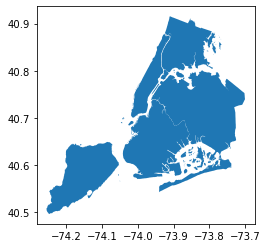

In [11]:
# Read in shapefile as a GeoPandas GeoDataframe. Very similar to pandas but with some metadata
shape=gpd.read_file('BoroughBoundaries/geo_export_38393e35-ee4f-452c-926a-fd0fd2836963.shp')
shape.plot()

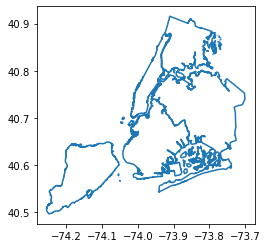

In [12]:
shape.boundary.plot()

In [13]:
type(shape) 

geopandas.geodataframe.GeoDataFrame

In [14]:
shape.crs # Metadata, important that this is the same projection (WGS 84) between geodataframes that interact

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The shape file when loaded in with GeoPandas is basically just a dataframe with each polygon as an entry. The polygons themselves are their own object type which strings together a list of coordinates.

In [15]:
shape.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.186612e+09,462958.187537,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,5.0,Staten Island,1.623757e+09,325956.009000,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,1.0,Manhattan,6.366027e+08,361212.476363,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3.0,Brooklyn,1.937593e+09,738745.842046,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
4,4.0,Queens,3.045878e+09,904191.432610,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."


#### A bounding box is a crude  but efficient way of handling the data. We will use it here to speed up our computation as it can get rid of the mostly obvious examples. From there we can use a more advanced method on more ambiguous answers. The bounding box will also serve to  bound the drop-offs, it seems a logical assumption that NYC taxis are more likely to pick up inside the city bounds and leave, than pickup outside the city bounds and come in. This logic could be extended to limiting pickups inside NYC and drop offs inside NY state.

#### The box here is just the min/max latitude and longitude of NYC, this could be easily extended to what you see fit.

In [67]:
# Get the max/min of each NYC precint
bounds_df = shape.bounds
bounds_df

,minx,miny,maxx,maxy
0,-73.933606,40.785357,-73.765332,40.915533
1,-74.255591,40.496115,-74.049236,40.648926
2,-74.047730,40.682917,-73.906651,40.879038
3,-74.041897,40.569530,-73.833559,40.739128
4,-73.962620,40.541834,-73.700009,40.801011


In [68]:
# Get the max/min of all the precincts so we can create a box around NYC
maxlong, maxlat, minlong, minlat = max(bounds_df['maxx']), max(bounds_df['maxy']), min(bounds_df['minx']), min(bounds_df['miny'])
maxlong, minlong, maxlat,  minlat

(-73.7000090638712, -74.25559136315213, 40.91553277600008, 40.49611539518921)

#### Flag all the data outside the bounding box with a identifying tag

In [18]:
# Any points at all outisde of this box will be labelled as bad data
df['bad_data_flag'] = np.where(df['pickup_latitude'] > maxlat, df['bad_data_flag'] + 'latitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['pickup_latitude'] < minlat, df['bad_data_flag'] + 'latitude below min ', df['bad_data_flag'])

In [19]:
df['bad_data_flag'] = np.where(df['pickup_longitude'] > maxlong, df['bad_data_flag'] + 'longitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['pickup_longitude'] < minlong, df['bad_data_flag'] + 'longitude below min ', df['bad_data_flag'])

In [20]:
df['bad_data_flag'] = np.where(df['dropoff_latitude'] > maxlat, df['bad_data_flag'] + 'latitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['dropoff_latitude'] < minlat, df['bad_data_flag'] + 'latitude below min ', df['bad_data_flag'])

In [21]:
df['bad_data_flag'] = np.where(df['dropoff_longitude'] > maxlong, df['bad_data_flag'] + 'longitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['dropoff_longitude'] < minlong, df['bad_data_flag'] + 'longitude below min ', df['bad_data_flag'])

In [22]:
df[df['bad_data_flag'] != ''].shape # Bad data

(113, 25)

#### Bounding box got rid 113 taxi trips which had any of their trip details start/end outside of the bounding box. 

#### We'll now operate on the leftover data.

In [23]:
df_after_bound = df[df['bad_data_flag'] == ''] # New dataframe with only good data

#### Get a list of the pickup points of every trip in a shapely.Point format so we can do polygonal comparison with the shapefile. Here we only use pickups because we are assuming that NYC taxis only pickup customers within the city limits.

In [24]:
geometry = [Point(xy) for xy in zip(df_after_bound['pickup_longitude'], df_after_bound['pickup_latitude'])] # zipping to columns into a Point(xy)

In [25]:
type(geometry[0])

shapely.geometry.point.Point

#### Turn the original data into a geodataframe with the previously calculated pickup points as the geometry for each trip. What we also do here is label each taxi trip with the name of the precinct in New York that the trip started. Trips that don't start inside the city will have a 'nan' in that place.

In [26]:
pickups = gpd.GeoDataFrame(df_after_bound, crs=shape.crs , geometry=geometry) # Turn those points into a gepdataframe with the same metadata

In [27]:
type(pickups)

geopandas.geodataframe.GeoDataFrame

#### The final dataset is created with a spatial join between the pickup locations and the NYC boundaries. Note that this also will exclude the spaces between boundaries and in the water. A spatial join basically treats the boundary dataset as a mask and attributed its information only to those data points that fall within the mask.

In [28]:
pointInPolys = sjoin(pickups, shape, how='left',op="within") # Spatial join between two geodataframes, shape is the mask

In [34]:
pointInPolys.head() # We have added new data to the dataframe

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,randID,dropoff_minus_pickup,bad_data_flag,tips_percent,geometry,index_right,boro_code,boro_name,shape_area,shape_leng
129,F0F0CFE0F353AAB5F87B98BC37C5540D,037BB8A7D2501F9CDCCC70F271A356D6,CMT,1,N,15800.216574,15800.223252,1,577,3.40,...,15,0.006678,,16.000000,POINT (-73.94615 40.77319),2.0,1.0,Manhattan,6.366027e+08,361212.476363
167,5C96FE79A28D617F9933C387A65A3061,BDDFA029563EC82E16C335A5B3B1C57F,VTS,1,,15807.981944,15807.989583,1,660,1.83,...,15,0.007639,,21.052632,POINT (-73.98113 40.74444),2.0,1.0,Manhattan,6.366027e+08,361212.476363
377,85720A3C71973D86C8CA39B0B79B6968,DEF7DC1592397F0C2564B0ABFA2A7CF4,VTS,1,,15807.835417,15807.845139,1,840,5.02,...,15,0.009722,,25.757576,POINT (-73.94755 40.78481),2.0,1.0,Manhattan,6.366027e+08,361212.476363
416,62099C3783738399C97EE0D4E35A3F0A,D2923683CFECDB4AECB0D995716F35FF,VTS,1,,15807.878472,15807.888889,1,900,2.84,...,15,0.010417,,0.000000,POINT (-73.99927 40.72501),2.0,1.0,Manhattan,6.366027e+08,361212.476363
481,CAC816D410FB0B7B8F3B4B1F39680F97,A9F126F43FAFF4097D227EA49EBCAEEF,VTS,1,,15807.923611,15807.930556,6,600,2.26,...,15,0.006944,,21.052632,POINT (-73.95654 40.77512),2.0,1.0,Manhattan,6.366027e+08,361212.476363


In [35]:
out_points = pointInPolys['geometry'][pointInPolys['boro_name'].isnull()] #points that are outside for graphing

#### Below we see a clear demonstration of the procedure working. The concern here is did it work too well? 

#### At this point it would be usefull to review how we feel about the boundaries and if too much data had been cut out. This would be a discussion with an SME or PO.

#### The first plot shows us all the trips with pickup locations outisde of NYC that have been 'cut' from the dataset. Some of these are in the water and so should be cut. However some seem to be just in the neighboring suburbs. Perhaps the shapefile could be updated to include every neighboring suburb. This could be an interesting extension

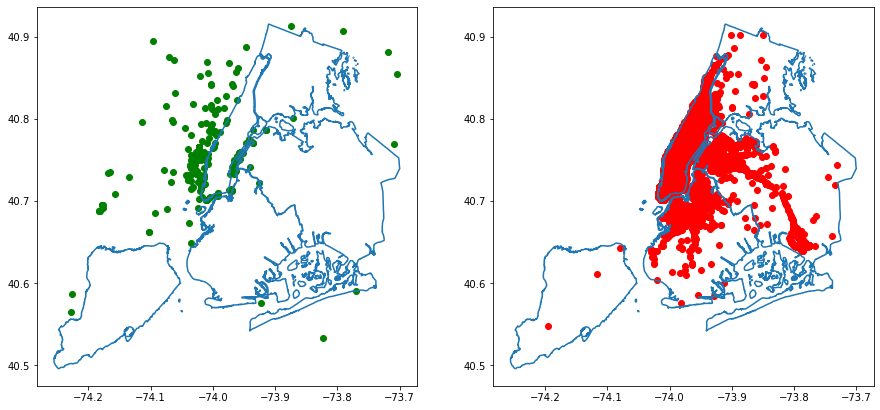

In [49]:
fig, (ax1, ax2) = plt.pyplot.subplots(ncols = 2, figsize = (15,15))
shape.boundary.plot(ax=ax1)
out_points.head(100000).plot(ax=ax1, color = 'green') # bad data
shape.boundary.plot(ax=ax2)
gpd.GeoDataFrame(pointInPolys['geometry'][pointInPolys['boro_name'].notnull()].head(100000)).plot(ax = ax2, color = 'red') # good data
plt.pyplot.show()

Depending on the bounding box this method may be very accurate and could exactly meet a clients requirements and definitions. It would be possible for the client to even create their own particular boundary map to work with. However it costs a lot in compute due to the size of the data. This could be improved but is out of scope for this notebook.

#### How much data did we remove? In total with both methods we removed around 387 points of data, or .26%, from our sample. This may or may not be significant enough to warrant a change based on the business case

In [66]:
original = df.shape[0] # original data length
bounded = pointInPolys[pointInPolys['boro_name'].isnull()].shape[0] # length of removed data after box
cleaned = original - pointInPolys[pointInPolys['boro_name'].notnull()].shape[0] # length of data at the end
shapefile = cleaned - bounded # length of data that NYC bounding removed

print(original, bounded, cleaned)
print("Bounding box removed: " + str(round(bounded/original * 100, 2)) + "%")
print("NYC shapefile removed: " + str(round(shapefile/original * 100, 2)) + "%")
print("In total we removed: " + str(round(cleaned/original * 100, 2)) + "%")

150493 274 387
Bounding box removed: 0.18%
NYC shapefile removed: 0.08%
In total we removed: 0.26%


#### Rechecking the spread of the data we can definitely see that we have improved the dataset.

In [42]:
pointInPolys['pickup_longitude'][pointInPolys['boro_name'].notnull()].describe()

count    150106.000000
mean        -73.975093
std           0.034507
min         -74.195213
25%         -73.992218
50%         -73.981979
75%         -73.967783
max         -73.705719
Name: pickup_longitude, dtype: float64

In [43]:
pointInPolys['pickup_latitude'][pointInPolys['boro_name'].notnull()].describe()

count    150106.000000
mean         40.750955
std           0.026968
min          40.548466
25%          40.736660
50%          40.753426
75%          40.767910
max          40.902767
Name: pickup_latitude, dtype: float64

In [44]:
pointInPolys['dropoff_longitude'][pointInPolys['boro_name'].notnull()].describe()

count    150106.000000
mean        -73.974735
std           0.032889
min         -74.240913
25%         -73.991539
50%         -73.980385
75%         -73.964966
max         -73.701385
Name: dropoff_longitude, dtype: float64

In [45]:
pointInPolys['dropoff_latitude'][pointInPolys['boro_name'].notnull()].describe()

count    150106.000000
mean         40.751354
std           0.030584
min          40.517826
25%          40.735523
50%          40.754028
75%          40.768566
max          40.912708
Name: dropoff_latitude, dtype: float64

## Things to try that could improve results

#### - Use a state shapefile instead
#### - Use a custome shapefile
#### - Bound the dropoffs with a state shape and pickups with NYC shape
#### - Include the surrounding suburbs

## What we missed?

### These are possible types of corrupt data that this method can not identify.

#### - Dropoff/Pickup points that are on top of eachother
#### - Dropoff/Pickup points that are closer than the trip meter reads